In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
llm = 'fine-tuned-MultipleNegativesRankingLoss'
#llm = 'fine-tuned-mpnet'

In [8]:
def get_result(config, folds=5):
    result = {}
    for fold in range(folds):  
        if os.path.exists(f'logs/{llm}/{config}_fold{fold}.txt'):
            result[fold] = {'train loss': [], 'train ndcg': [], 'test ndcg': [], 'train prec': [], 'test prec': []}
            with open(f'logs/{llm}/{config}_fold{fold}.txt', 'r') as f:
                for line in f:
                    terms = [float(x) for x in line.split()]
                    result[fold]['train loss'].append(terms[0])
                    result[fold]['train ndcg'].append(terms[1:5])
                    result[fold]['test ndcg'].append(terms[5:9])
                    result[fold]['train prec'].append(terms[9:13])
                    result[fold]['test prec'].append(terms[13:17])
    return result

In [9]:
def get_best_config(results, folds=5, epoch=40):
    best_result = (-1, None, None, None)

    for config in results.keys():
        ndcg = np.array([results[config][fold]['test ndcg'][epoch-1] for fold in range(folds)])
        prec = np.array([results[config][fold]['test prec'][epoch-1] for fold in range(folds)])
        
        ndcg = np.mean(ndcg, 0)
        prec = np.mean(prec, 0)
        
        #if np.mean(ndcg) + np.mean(prec) > best_result[0]:
        #    best_result = (np.mean(ndcg) + np.mean(prec), config, ndcg, prec)
        
        #if ndcg[0] + prec[0] > best_result[0]:
        #    best_result = (ndcg[0] + prec[0], config, ndcg, prec)
        if ndcg[0] > best_result[0]:
            best_result = (ndcg[0], config, ndcg, prec)
        
    return best_result[1], best_result[2], best_result[3]

In [10]:
def get_best_config_epoch(results, folds=5):
    best_result = (-1, None, None, None)

    for config in results.keys():
        if len(results[config][4]['test ndcg']) != 5:
            continue
        for epoch in range(1,6):
            ndcg = np.array([results[config][fold]['test ndcg'][epoch-1] for fold in range(folds)])
            prec = np.array([results[config][fold]['test prec'][epoch-1] for fold in range(folds)])

            ndcg = np.mean(ndcg, 0)
            prec = np.mean(prec, 0)

            score = ndcg[0]
            if score > best_result[0]:
                best_result = (score, config, ndcg, prec, epoch)
            
            
            
    return best_result[1], best_result[2], best_result[3], best_result[4]

In [13]:
dataset = 'clueweb09b_123'
dataset = 'gov2'
dataset = 'clueweb09b_100'
dataset = 'fedweb14'
folds = 5

loss_type = 'hinge'
use_gnn = 1
bias = 1
version = 3
num_doc = 100

config_list = []

for learning_rate in [0.00005, 0.00001]:
    for weight_decay in [0.001, 0.0001, 0.00001]:
        for dim in [512]:
            for gamma in [0.0, 0.1, 0.5, 1.0, 5.0]:
                _config = f'{dataset}_lr{learning_rate}_wd{weight_decay}_dim{dim}_gamma{gamma}_bias{bias}_loss-{loss_type}'

                if loss_type == 'hinge':
                    for delta in [0.5, 1.0, 5.0, 10.0]: 
                        if use_gnn:
                            for thresh in [0.1, 0.5, 0.9]:
                                config = _config + f'_delta{delta}_gnn{thresh}'
                                config_list.append(config + f'_ver{version}_doc{num_doc}')
                        else:
                            config = _config + f'_delta{delta}'
                            config_list.append(config + f'_ver{version}_doc{num_doc}')
                elif use_gnn:
                    for thresh in [0.1, 0.5, 0.9]:
                        config = _config + f'_gnn{thresh}'
                        config_list.append(config + f'_ver{version}_doc{num_doc}')
                else:
                    config = _config
                    config_list.append(config + f'_ver{version}_doc{num_doc}')

In [14]:
results = {}

completed = []

for config in config_list:
    result = get_result(config, folds)
    if len(result) == folds:
        completed.append(1)
        results[config] = result
    else:
        completed.append(0)
        
print(f'Completed: {sum(completed)} / {len(completed)}')

#epoch=5
best_config, best_ndcg, best_prec, best_epoch = get_best_config_epoch(results)
#best_config, best_ndcg, best_prec = get_best_config(results, epoch=epoch)

print(best_config)
print('best epoch', best_epoch)
print(' '.join([str(x) for x in best_ndcg.tolist() + best_prec.tolist()]))
print(best_ndcg, np.mean(best_ndcg))
print(best_prec, np.mean(best_prec))
print()

Completed: 360 / 360
fedweb14_lr1e-05_wd0.001_dim512_gamma0.1_bias1_loss-hinge_delta10.0_gnn0.1_ver3_doc100
best epoch 4
0.8114740381550943 0.7834170121903298 0.790323666469888 0.8137388117770378 0.8114740381550941 0.7845149526436065 0.7953821652415054 0.842973670536298
[0.81147404 0.78341701 0.79032367 0.81373881] 0.7997383821480876
[0.81147404 0.78451495 0.79538217 0.84297367] 0.8085862066441261



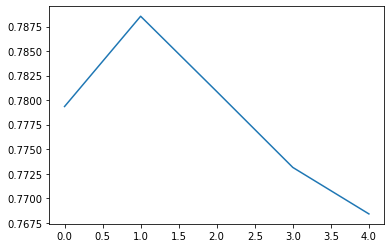

In [23]:
test_ndcg_5 = np.mean([[result[1] for result in results[best_config][fold]['test ndcg']] for fold in range(5)], 0)
plt.plot(test_ndcg_5)
plt.show()

In [574]:
logs = []

for fold in range(5):
    with open(f'ranks/{llm}/{best_config}_epoch{best_epoch-1}_fold{fold}.txt', 'r') as f:
        for line in f:
            logs.append(line)
            
with open(f'{dataset}_result.txt', 'w') as f:
    for line in logs:
        f.write(line)

In [84]:
results[config][0]['train ndcg']

KeyError: 'gov2_lr5e-05_wd1e-05_dim512_gamma1.0_bias1_loss-hinge_delta10.0_gnn0.9_ver3_doc100'